In [1]:
import numpy  as np
from scipy import sparse
from scipy.sparse import csc_matrix, linalg as sla 
import re
import math
import matplotlib.pylab as plt
import os


In [2]:
# dimension de la matrice Jacobienne initiale

size_j = 273

# nombre de variables différentielles dans la matrice Jacobienne initiale 

n_dv_i = 127

print("Définition des paramètres du problème ...", "\nDimension de la matrice Jacobienne J : " 
+ str(size_j)+"x"+str(size_j),"\nNombre de variables différentielles initiale  "+ str(n_dv_i))


Définition des paramètres du problème ... 
Dimension de la matrice Jacobienne J : 273x273 
Nombre de variables différentielles initiale  127


In [3]:
# Fonction qui retourne une list correspondant aux inputs si le nom du fichier est "inputs.log" ou aux outputs si le nom du fichier est "outputs.log"

def load_io(filename):

    file = open(filename,'r')
    lines = file.readlines()
    count = 0
    numbers = []
    names = []

    for line in lines:

        if count !=0:

            #x  = re.findall(,"" line )
            if count >=1:

                    
                    name = ""
                    number = ""
                    boolean = False
                    number_reading = False
                    name_reading = False
                    space_counter = 0
                    count2  = 0

                    while count2 < len(line):

                        if line[count2] == ":":
                            space_counter = count2
                            number_reading = True
                           
                    
                        if count2 >= space_counter +2 and number_reading is True:
                            
                            if line[count2].isdigit():
                             number = number + line[count2]
                            else:
                                number_reading = False
                        if line[count2]== ")":
                            break
                        if name_reading:
                            
                            name = name + line[count2]
                        if line[count2] == "(":
                            name_reading = True
                            
                        count2 +=1
                    
                    numbers.append(int(number))
                    names.append(name)

        count = count +1

    return [numbers, names]

In [4]:
# Mets les inputs donnés dans test_api.log dans une list

inputs,inputs_names = load_io('inputs.log')

#  Mets les outputs donnés dans test_api.log dans une list

outputs,outputs_names = load_io('outputs.log')



In [5]:
# on garde uniquement les inputs qui ne sont pas des outputs et les outputs qui ne sont pas des inputs.
# inp : list contenant les inputs
# out : list contenant les outputs
# retourne : inpt : inputs qui ne sont pas des outputs
#           outpt : outputs qui ne sont pas des inputs


def keep_relevant_io(inp,inp_names,out,out_names):

    inpt = []
    outpt=[]
    inpts_names = []
    outpts_names = []
    count = 0

    for elem in inp:

        if elem not in out:
            inpt.append(int(elem))
            inpts_names.append(inp_names[count])

        count = count + 1

    count = 0

    for elem in out:

        if elem not in inp:

            outpt.append(int(elem))
            outpts_names.append(out_names[count])

        count = count +1 
    return [inpt,inpts_names, outpt,outpts_names]

In [6]:

[relevant_inputs,relevant_inputs_names,relevant_outputs,relevant_outputs_names] =keep_relevant_io(inputs,inputs_names,outputs,outputs_names)


print('Création des listes relevant_inputs et relevant_outputs qui ne contiennet que les inputs/outputs pertinents')
print("nombre d'inputs pertinents: ",len(relevant_inputs))
print("nombre d'outputs pertinents: ",len(relevant_outputs))



Création des listes relevant_inputs et relevant_outputs qui ne contiennet que les inputs/outputs pertinents
nombre d'inputs pertinents:  7
nombre d'outputs pertinents:  1


In [7]:
# Le fichier Afull contient les lignes et les colonnes de départ (donc de la matrice Jacobienne de base)
# Pour réduire la taille de Afull et ne pas avoir à garder des lignes/Colonnes nulles, on supprime ces lignes colonnes
# La suppresion de ces lignes/col nécessite de modifier la valeur des lignes/colonnes restantes.
# Pour savoir comment modifier ces l/c restantes, on a besoin connaitre les variables initialement supprimés de la matrice jacobinne.
# cette fonction a pour but de mettre ces variables dans une list en prenat comme argument les inputs et les outputs.


def compute_variables_removed(inp, out):

    var = []
    var = inp

    for elem in out:

        if elem not in var:

            var.append(elem)
    
    var.sort()
    
    return var

In [8]:

# List contentant les variables supprimés de la matrice Jacobienne initiale 

variables = compute_variables_removed(inputs,outputs)

print("nombre de variables supprimées de la matrice Jacobienne initiale :",len(variables))


nombre de variables supprimées de la matrice Jacobienne initiale : 8


In [9]:
# cette fonction a pour but de retourner le nombre de variables differentielles restantes dans le probleme .
# elle prend comme argument : var ( ma list contenant les variables supprimées de la matrice jacobienne ) et number : le nombre de variables différentielles initiales


def compute_number_of_differential_variables(var, number):

        n =number

        for elem in var:
            if elem <= number:
                n = n-1
        return n 


In [10]:

n_dv = compute_number_of_differential_variables(variables, n_dv_i)

print("le nombre de variables différentielles restantes dans Afull = ",n_dv)

le nombre de variables différentielles restantes dans Afull =  127


In [11]:
# Mainteant qu'on a les variables qui ont été supprimés de la matrice jacobienne initiale, on peut modifer les lignes/colonnes restantes
# pour avoir une matrice Afull plus petite.
# cette fonction prend comme argument r( une ligne) et c (une colonne) de Afull et var( les variables supprimées)
# pour une colonne de Afull c, on regarde le nombre de colonnes supprimés de J avant n et on fait c-n pour trouver la nouvelle colonne correspondante à c
# pareil pour les lignes.
# l'algo effectue cela pour c et r en même temps en parcourant dans var les variables supprimés si durant ce parcours la varibale de var dépasse
# l'élément le plus grand entre c et r , on s'arrête car la suppresion d'une ligne ou colonne plus grande ne va pas induire de changement.

def compute_row_col_shifted(r,c,var):

    # initialise le  shift de la ligne r  à 0
    shift_r = 0

    # initialise le shit de la colone c à 0
    shift_c = 0

    # On arrête l'algortihme lorsqu'on a calculé le shit de la plus grande valeur entre r et c
    
    stop = max(r,c)

    for elem in var:
        
        # si l'element des variables supprimés est plus grand que la plus grande valeur entre r et c, on peut arrêter l'algorithme car on aura pas
        # de changement dans le shift de la ligne r ou la colonne c induit par la suppression  d'une ligne ou d'une colonne plus grande .
        
        if(elem > stop):

            break

        else:

            # si la ligne r est plus grande que l'element elem de la liste variables enlevés de la matrice jacobienne, on augmente la valeur du shift par  1

            if r > elem:

                shift_r = shift_r +1

            #  si la colonne r est plus grande que l'élement elem de la liste de variables enlevés de la matrice jacobienne , on augmente la valeur du shit par 1
            
            if c > elem:

                shift_c = shift_c +1

    # return the shifted row and col 
    return [r- shift_r,c-shift_c]


In [12]:
# Fonction qui retourne la matrice Afull si filename = 'Afull.log', Bfull si filename = 'Bfull.log' et Cfull si filename = 'Cfull.log'
# Il est plus optimal de réduire la taille de la matrice Afull en tenant compte des variables qui ont été enlevés de la matrice Jacobienne initiale.
#  les arguments var,inp,out correspondent à la liste des variables enlevés (variables ), des inputs pertinents (relevent_inputs), des outputs pertinents (relevant_outputs)


def load_matrices(filename,var,inp,out):
    
    val,col,row = [],[],[]

    # on essaye d'ouvrir le fichier

    try:

        file = open(filename,'r')

    except:
        # si cette ouverture echoue c'est que le fichier n'est pas disponible

        print("le fichier " +filename + " n'est pas disponible! ")
        return 0

    filesize = os.path.getsize(filename)
    print(filename + " " +str(filesize))

    if filesize>6:

        lines = file.readlines()

        count = 0

        retour = []

        if filename== 'Afull.log':

            # on met un élement non-nul dans la diagonal de A1
            for i in range(n_dv):
                row.append(i)
                col.append(i)
                val.append(1)

            # Pour créer un Afull plus petit, on va utiliser la fonction compute_row_col_shifted.

            for line in lines:
                
                if count!=0:

                    x  = re.findall('[+-]?\d+(?:\.\d+)?', line )

                    # r correspond à la ligne de Afull
                    r = (int(float(x[0])) )
                    # c correspond à la colonne de Afull
                    c = (int(float(x[1])))

                    # on veut réduire Afull donc on utilise la fonction décrite précedemment pour voir à quel ligne on va mettre r et quelle colone on va mettre c
                    
                    [r,c] = compute_row_col_shifted(r,c,var)

                    # on soustrait 1 car le premier element d'une list a pour indice 0 et dans le fichier le premier element d'une ligne/col a pour indice 1

                    row.append(r-1)
                    col.append(c-1)

                    # on mutliplie par -1 car en créant la matrice du systeme, on en a besoin.
                    val.append(-1*float(x[2]))


                count = count +1

            retour = csc_matrix((val,(row,col)),dtype="complex")
            
        if filename == 'Bfull.log':

            for line in lines:
                
                if count!=0:
                    
                    #  vecteur contenant (row,col,val)  lu à la ligne line de Bfull.log

                    x  = re.findall('[+-]?\d+(?:\.\d+)?', line )

                    # colonne lu dans Bfull.log

                    c = int(float(x[1]))

                    # on met la colonne c dans la matrice Bfull uniquement si elle correspond à un input pertinent
                
                    if c in inp:

                        # ligne lu dans Bfull.log

                        r = (int(float(x[0])))
                        
                        
                        #  la colonne c va de venir la colonne = à son indice dans inp ( inputs pertinents )
                        # ex la colonne 26 de Bfull.log va devenir la colonne 0 car c'est le premier input pertinent qu'on a.

                        col.append(inp.index(c))

                        # Pour savoir à quelle ligne de Bfull on va mettre la ligne r de Bfull.log, on utilise la fonction décrite précédement.
                        # ps la fonction prend 2 arguments r et c, ici on met c mais on va pas utiliser le résultat.

                        [r,c] = compute_row_col_shifted(r,c,var)

                        # on ajoute la nouvelle ligne calculée à row

                        row.append(r-1)

                        # on ajoute la valeur lue à la ligne line de BFull.log à la list val

                        val.append(float(x[2]))

                # on passe à une autre ligne de Bfull.log

                count = count +1

            # return the matrix in csc format

            retour = csc_matrix((val,(row,col)),dtype="complex")
        
        if filename == "Cfull.log":

            for line in lines:
                
                if count!=0:
                    # ecteur contenant (row,col,val)  lu à la ligne line de Cfull.log

                    x  = re.findall('[+-]?\d+(?:\.\d+)?', line )

                    # ligne (row)  lu dans Bfull.log

                    r = (int(float(x[0])))
                    
                    # On met uniquement cette ligne dans la matrice Cfull si elle correspond à un output pertinent .

                    if r in out:
                        
                        #  la ligne  r va de venir la ligne  = à son indice dans out ( outputs pertinents )
                        # ex la ligne 23 de Cfull.log va devenir la ligne  0 car c'est le premier output pertinent qu'on a.

                        row.append(out.index(r))

                        #  la colonne lue dans Cfull.log

                        c = (int(float(x[1])))

                        # Pour savoir à quelle colonne  de Cfull on va mettre la colonne  c de Cfull.log, on utilise la fonction décrite précédement.
                        # ps la fonction prend 2 arguments r et c, ici on met r mais on va pas utiliser le résultat.

                        [r,c] = compute_row_col_shifted(r,c,var)

                        # on ajoute la colonne à la list col 

                        col.append(c-1)

                        # on ajoute la valeur correspondante lue dans Cfull.log

                        val.append(float(x[2]))

                # on passe à une nouvelle ligne de Cfull.log
                count = count +1
                
            # return the matrix in csc format
            retour = csc_matrix((val,(row,col)),dtype="complex")

        if filename == 'Dfull.log':
                
                for line in lines:

                    if count!=0:

                        # ecteur contenant (row,col,val)  lu à la ligne line de Cfull.log

                        x  = re.findall('[+-]?\d+(?:\.\d+)?', line )

                        # ligne (row)  lu dans Bfull.log

                        r = (int(float(x[0])))

                        c = (int(float(x[1])))
                        
                    # On met uniquement le couple (r,c) dans la matrice Dfull si il correspond à un couple (output/input)

                        if r in out and c in inp:
                            
                            # la ligne dans lequelle on va mettre cet élément est l'index de l'ouput correspondant à cette ligne dans la liste des outputs pertinents
                            # la colonnne  dans laquelle on va mettre cet élément est l'index de l'input pertinent correspondant à cette colonne dans la liste des inputs pertinents


                        
                            row.append(out.index(r))
                            col.append(inp.index(c))
                        
                            # on ajoute la valeur correspondante lue dans Cfull.log

                            val.append(float(x[2]))
                            
                # on passe à une nouvelle ligne de Cfull.log
                    count = count +1
                
                # return the matrix in csc format
                retour = csc_matrix((val,(row,col)),dtype="complex")

    else:
            # si le fichier ouvert ne contient pas de données autre que son nom (ex Dfull, on retourne 0)

            retour = 0

    return retour

In [13]:
print("Chargement des matrices Afull, Bfull & Cfull ...")

Afull = load_matrices("Afull.log",variables,relevant_inputs,relevant_outputs)

# obtenir la taille de Afull
size_Af = Afull.shape[0]

print("dimension de Afull ", Afull.shape)


Bfull = load_matrices("Bfull.log",variables,relevant_inputs,relevant_outputs)

print("dimension de Bfull ",Bfull.shape)

# La matrice Bfull peut contenir moins de lignes que Afull car  Ici elle est construite de manière à ne contenir que les lignes non-nulles
# Ce qui peut diminuer son nombre de lignes, Cela n'a pas d'effet car lors du choix de la colonne de Bfull correspondant à l'input, cette colonne est étendu
# pour avoir autant de lignes que Afull.


Cfull = load_matrices("Cfull.log",variables,relevant_inputs,relevant_outputs)

# La matrice Cfull peut contenir moins de colonnes que Afull car elle est construite de manière à ne contenir que les colonnes non-nulles, ce qui
# peut diminuer son nombre de colonnes, Cela n'a pas d'effet car lors du choix de la ligne de Cfull correspondant à l'output, cette ligne est étendue
# de manière à avoir autant de colonnes que Afull


print("dimension de Cfull ",  Cfull.shape)


Dfull = load_matrices("Dfull.log",variables,relevant_inputs,relevant_outputs)

isD = False

try:
        print("dimension de Dfull ", Dfull.shape)
        isD = True
except:

        print("La matrice Dfull est nulle dans ce cas !")







Chargement des matrices Afull, Bfull & Cfull ...
Afull.log 40571
dimension de Afull  (265, 265)
Bfull.log 201
dimension de Bfull  (125, 7)
Cfull.log 33
dimension de Cfull  (1, 172)
Dfull.log 5
La matrice Dfull est nulle dans ce cas !


In [14]:
# chaque colonne de Bfull correspond à un input en fournissant à cette fonction l'index de la colonne correspondant à l'input et la matrice Bfull
# on peut trouver cette colonne.
# ensuite on a besoin de connaitre la taille de Afull pour étendre notre colonne car sa taille put être inférieure au nombre de lignes de Afull
# ce qui posera porblème lors du produit matricielle l'inverse de Afull et cette colonne.

# la fonction a besoin de index : l'index de la colonne que l'on souhaite dans Bfull, mat : la matrice Bfull, sizeA : nombre de lignes de Afull

def get_input_col_vector(index,mat,sizeA):


        n_col_a = sizeA

        # on obtient la colonne index de Bfull

        b = mat.getcol(index)
        

        # on initialize un vecteur  contenant uniquement des zéros ayant une taille correspondant aux nombres de col/ligne de Afull

        b_array = np.zeros((n_col_a,1),dtype= "complex64")

        count =0

        # on parcourt les lignes elem de la colonne b de Bfull, on met les valeurs (b.data) correspondant à la ligne elem dans la ligne elem de b_array
        
        for elem in b.indices:

            b_array[elem] = b.data[count]

            count = count +1

        return b_array

In [15]:
# chaque ligne  de Cfull correspond à un output en fournissant à cette fonction l'index de la ligne correspondant à l'outputt et la matrice Cfull
# on peut trouver cette  ligne.
# ensuite on a besoin de connaitre la taille de Afull pour étendre notre ligne car elle peut avoir un nombre de colonnes inférieures aux nombres
# de colonnes de Afull ce qui peut poser problème lors du produit sclaire entre cette ligne et le vecteur d'état.

# la fonction a besoin de index : l'index de la ligne  que l'on souhaite dans Cfull, mat : la matrice Cfull, sizeA : nombre de lignes de Afull

def get_output_row_vector(index,mat,sizeA):

    
    # on définit le nombre de colones/lignes de Afull
    
    n_col_a = sizeA

    # on obtient la ligne index de Cfull

    c = mat.getrow(index)
   
    # on initialize un vecteur  contenant uniquement des zéros ayant une taille correspondant aux nombres de col/ligne de Afull


    c_array = np.zeros((n_col_a,1),dtype="complex64")

    
    count = 0

    # on parcourt les col  elem de la ligne c de Cfull, on met les valeurs (c.data) correspondant à la colone elem dans la colonne elem de c_array

    for elem in c.indices:

        c_array[elem] = c.data[count]
        count = count +1

    return c_array

In [16]:
# Cette fonction a pour but de donner à l'utilisateur le choix de la variable d'input pour laquelle il souhaite calculer la fonction de transfer.
# Elle prend comme argument :  inpts ( la liste contenants les inputs pertinents ), str ( le message à afficher pour l'utilisateur )

def choose_input(inpts,str):

        inp = input(str)

        if inp.isdigit():

            if int(inp) in inpts:

                return int(inp)
                
            else:
                return  choose_input(inpts,"Input non disponible , Choisissez à nouveau !")

        else:

           return  choose_input(inpts,"Input non disponible , Choisissez à nouveau !")

In [17]:
# Cette fonction a pour but de donner à l'utilisateur le choix de la variable d'output pour laquelle il souhaite calculer la fonction de transfer.
# Elle prend comme argument :  outpts ( la liste contenants les outputs pertinents ), str ( le message à afficher pour l'utilisateur )
def choose_output(outpts,str):

        out = input(str)

        if out.isdigit():

            if int(out) in outpts:

                return int(out)
            else:

                return choose_output(outpts,"Output non disponible , Choisissez à nouveau !")
        else:

           return  choose_output(outpts,"Output non disponible , Choisissez à nouveau !")
    

In [18]:

print("Choisissez l'input souhaité parmi les éléments de la liste suivante : \n",relevant_inputs)


Choisissez l'input souhaité parmi les éléments de la liste suivante : 
 [134, 142, 150, 158, 166, 174, 178]


In [19]:
input_number = choose_input(relevant_inputs,"Choisissez un input à partir de la liste précédente  \n")

print("Input :" ,input_number)

Input : 178


In [20]:
print("Choisissez l'output souhaité parmi les éléments de la liste suivante  \n",relevant_outputs)


Choisissez l'output souhaité parmi les éléments de la liste suivante  
 [180]


In [21]:
output_number = choose_output(relevant_outputs,"Choisissez un output à partir de la liste précédente \n")

print("Output :",output_number)

Output : 180


In [22]:



# compute right-hand side of the equation Ax=b which correspond to the given input

b = get_input_col_vector(relevant_inputs.index(input_number),Bfull,size_Af)

print("la colonne  de Bfull correspondant à l'input a été stockée dans b  ...")


la colonne  de Bfull correspondant à l'input a été stockée dans b  ...


In [23]:



# compute the row of Cfull wich correspond to the given output

c = get_output_row_vector(relevant_outputs.index(output_number),Cfull,size_Af)

print("La ligne de Cfull correspondant à l'output à été stockée dans c ...")


La ligne de Cfull correspondant à l'output à été stockée dans c ...


In [24]:
# cette fonction a pour but de fournir l'élement à ajouter à la fonction de transfert. C'est l'element à la ligne de l'output et la colonne de l'input de Dfull

def get_d_value(mat,input_index, output_index):

    
    mat = mat.toarray()

    d = mat[output_index,input_index]

    return d

In [25]:
d_value = 0



if isD:

    try:
        d_value = get_d_value(Dfull,relevant_inputs.index(input_number),relevant_outputs.index(output_number))
    except:
        d_value = 0


            
print("valeur à ajouter à la function de transfert provenant de Dfull : ", d_value)
#d_value = 0



valeur à ajouter à la function de transfert provenant de Dfull :  0


In [26]:
# Cette fonction a pour but de créer la matrice  [sI -A1 -A2
#                                                 -A3    -A4]
# A partir de la matrice         [-A1  -A2
#                                -A3  -A4]

# Ces arguments sont:
# mat : La matrice Afull 
# nvd : Le nombre de variables différentielles restantes dans Afull
# freq : La fréquence souhaitée


def create_system_matrix(mat, nvd, freq):
  
   # on effectue une copie de la matrice d'entrée

    S = mat.copy() 


    # matrice S contient déjà des elements sur la diagonal de A1 pour éviter de changer la structure de la matrice CSC.

    #  indptr est un vecteur contenant les indices de début de chaque colonne et le dernier element correspond à l'indice de début d'une colonne fictive supplémentaire

    indptr = S.indptr

    # row contient les lignes correspondants à chaque élements de  la matrice CSC mat

    row = S.indices

    
    # on parcourt toutes les colonnes de A1 restantes , i represente la colonne, j represente l'indice dans la matrice CSC mat d'un élement de la colonne i
    # si row[j] == i cela veut dire que c'est un élement diagonal, on le modifie.
    # break pour sortir de la boucle.

    for i in range(nvd):
        
        for j in range(indptr[i],indptr[i+1]):

            if row[j] == i:

                # -1 car on a ajouté un sur la diagonal.
                S.data[j] = complex(S.data[j] -1, freq)
                break
    return S

  

    

In [27]:
# On définit un vecteur contenant les fréquences pour lesquelles on souhaite calculer la fonction de transfert 

frequencies = np.logspace(-1,2,100)

# On initialise les listes dans lesquelles on va stocker les valeurs de la fonction de transfert, son module, et la phase correspondante

transfer_function, modulus_of_tf, phases = [],[],[]

# On crée un fichier 'transfer_function.txt' dans lequel on va stocker la fréquence, la valeur de la fonction de transfert, son module et sa phase.

file = open('transfer_function.txt',"w")
file.write("This file contains the transfer function between the following input and output \n\n")

file.write("\nInput : " +str(input_number) +  " " +relevant_inputs_names[relevant_inputs.index(input_number)] + "\n")
file.write("\nOutput : " +str(output_number) +  " " +relevant_outputs_names[relevant_outputs.index(output_number)] + "\n" + "\n")


file.write("frequency            transfer_function                   modulus                    phases \n" )


92

In [28]:
### looping over the frequencies to find the tf

for frequency in frequencies:



    S = create_system_matrix(Afull,n_dv,frequency)

  

    # compute the LU factorization

    LU = sla.splu(S)

    # solve the equation usig b as the right-hand side

    x = LU.solve(b)

    x = np.squeeze(np.asarray(x))
  
    
    # dot product between x and c to obtain the TF

    value = x.dot(c)

    value = value + d_value
    # get the angle of array containing complex values

    phase = np.angle(value)

    # add the TF, moduleTF, angle in corresponding arrays

    transfer_function = np.append(transfer_function,value)

    modulus_of_tf = np.append(modulus_of_tf,abs(value))
    
    phases = np.append(phases,phase*180/math.pi)

    file.write( str(frequency) + "       " + str(value) + "             " + str(abs(value))+ "            " + str(phase)+"\n")





file.close()

print("Le calcul de la fonction de transfert, son module, sa phase a été efféctué pour les différentes frequences..")
print(" Ces valeurs sont stockées dans le fichier  'transfer_function.txt' ...")

Le calcul de la fonction de transfert, son module, sa phase a été efféctué pour les différentes frequences..
 Ces valeurs sont stockées dans le fichier  'transfer_function.txt' ...


Affichage du module de la fonciton de transfert en fonction de la fréquence ...


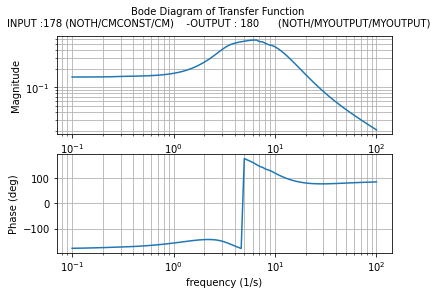

In [29]:
print("Affichage du module de la fonciton de transfert en fonction de la fréquence ...")
plt.subplot(2,1,1)
plt.plot(frequencies,modulus_of_tf)
plt.yscale('log')
plt.ylabel("Magnitude")
plt.grid(True, which = 'both')
plt.xscale('log')
plt.xlabel("frequency (1/s)")
plt.subplot(2,1,2)
plt.plot(frequencies,phases)
plt.ylabel("Phase (deg)")
plt.grid(True, which = 'both')
plt.xscale('log')
plt.xlabel("frequency (1/s)")
plt.suptitle("Bode Diagram of Transfer Function \n"+'INPUT :'+str(input_number) +' ('+relevant_inputs_names[relevant_inputs.index(input_number)] +')'+"   " +' -OUTPUT : ' +str(output_number)
+ '      ('+relevant_outputs_names[relevant_outputs.index(output_number)] +')',fontsize = 10)
fig1 = plt.gcf()
fig1.set_facecolor("w")
plt.show()
fig1.savefig("TF_BODE_DIAGRAM_INPUT_"+str(input_number)+"_OUTPUT_"+str(output_number))
